### This notebook walks through the key steps for doing a variational tensor network simulation of Gaussian boson sampling

Import the necessary modules

In [7]:
import numpy as np
import thewalrus as tw
import torch
import quimb.tensor as qtn
import matplotlib.pyplot as plt

### 1. Define the GBS problem.
Generate or load a covariance matrix. Displacements can be dealt with as a post-processing step if necessary.

In [3]:
N = 5
D = 10
seed = 0

np.random.seed(seed)

cov = tw.random.random_covariance(N, pure=True)
assert tw.quantum.is_pure_cov(cov)

### 3. Construct the Hamiltonian
Much of this code is contained in "script.py" but here we construct the MPO for the Hamiltonian explicitly. There are also other numerically approximate ways of obtaining the MPO in order to skip the step of deriving and implementing the MPO.

In [16]:
_extra = 1 #1 is enough for this example. It depends on the power of the X and P matrices in the Hamiltonian.
_a = np.diag([np.sqrt(i) for i in range(1,D + _extra)],1)
_Id = np.eye(D + _extra)
X = (_a + _a.T) / np.sqrt(2)
P = 1j * (_a.T - _a) / np.sqrt(2)

Id = _Id[:D,:D]

In [17]:
def get_MPO(cov):
    
    covdet1 = cov/np.power(np.linalg.det(cov),1/2*N) #Account for varying value of hbar (might as well set it to 2, because then the determinant equals 1.)
    H = np.linalg.inv(covdet1)/2

    a = 2 * H[:N,:N].real
    b = 2 * H[N:,N:].real
    c = 2 * H[:N,N:].real
    def construct_MPO_cores(n):

        if n == 0:

            def MPO_core_gauss(X,P):
                SingleSite = (a[n,n]/2 * X@X + b[n,n]/2 * P@P + c[n,n]/2 * ( P@X + X@P ) - 0.5*_Id)[:D,:D]
                S = np.zeros((4,D,D),dtype=np.complex128)
                for i, mat in enumerate([X[:D,:D],P[:D,:D],SingleSite,Id]):
                    S[i] = mat
                return S

        elif n == N-1:

            def MPO_core_gauss(X,P):
                SingleSite = (a[n,n]/2 * X@X + b[n,n]/2 * P@P + c[n,n]/2 * ( P@X + X@P ) - 0.5*_Id)[:D,:D]
                S = np.zeros((4,D,D),dtype=np.complex128)
                for i, mat in enumerate([X[:D,:D],P[:D,:D],Id,SingleSite]):
                    S[i] = mat
                return S

        elif n < N//2:
            
            def MPO_core_gauss(X,P):
                SingleSite = (a[n,n]/2 * X@X + b[n,n]/2 * P@P + c[n,n]/2 * ( P@X + X@P ) - 0.5*_Id)[:D,:D]
                X = X[:D,:D]
                P = P[:D,:D]

                S = np.zeros((2*(n+1),2*(n+1)+2,D,D),dtype=np.complex128)
                diag_inds = tuple(i for i in range(2*n)) + (-2,-1)
                S[diag_inds,diag_inds] = Id
                S[-1,2*n] = X
                S[-1,2*n+1] = P
                S[-1,2*n+2] = SingleSite
                for n_left in range(n):
                    S[2*n_left,2*n+2] = a[n_left,n]*X + c[n_left,n]*P
                    S[2*n_left+1,2*n+2] = c[n,n_left]*X + b[n_left,n]*P
                return S
            
        elif n == N//2:
            if N%2 == 0:
                Sshape0 = N+2
                Sshape1 = N
            else:
                Sshape0 = N+1
                Sshape1 = N+1
            
            def MPO_core_gauss(X,P):
                SingleSite = (a[n,n]/2 * X@X + b[n,n]/2 * P@P + c[n,n]/2 * ( P@X + X@P ) - 0.5*_Id)[:D,:D]
                X = X[:D,:D]
                P = P[:D,:D]
                S = np.zeros((Sshape0,Sshape1,D,D),dtype=np.complex128)
                for i in range(Sshape0//2 - 1):
                    for j in range(Sshape1//2 - 1):
                        j_tilde = N-1-j
                        S[2*i,2*j] = a[i,j_tilde]*Id
                        S[2*i,2*j+1] = c[i,j_tilde]*Id
                        S[2*i+1,2*j] = c[j_tilde,i]*Id
                        S[2*i+1,2*j+1] = b[i,j_tilde]*Id
                    S[2*i,-2] = a[i,N//2]*X + c[i,N//2]*P
                    S[2*i+1,-2] = c[N//2,i]*X + b[i,N//2]*P
                for j in range(Sshape1//2 - 1):
                    j_tilde = N-1-j
                    S[-1,2*j] = a[N//2,j_tilde]*X + c[j_tilde,N//2]*P
                    S[-1,2*j+1] = c[N//2,j_tilde]*X + b[N//2,j_tilde]*P
                S[(-2,-1),(-2,-1)] = Id
                S[-1,-2] = SingleSite
                return S
        
        elif n > N//2:
            
            def MPO_core_gauss(X,P):
                SingleSite = (a[n,n]/2 * X@X + b[n,n]/2 * P@P + c[n,n]/2 * ( P@X + X@P ) - 0.5*_Id)[:D,:D]
                X = X[:D,:D]
                P = P[:D,:D]
                S = np.zeros((2*(N+1-n),2*(N-n),D,D),dtype=np.complex128)
                diag_inds = tuple(i for i in range(2*(N-n-1))) + (-2,-1)
                S[diag_inds,diag_inds] = Id
                S[-4,-2] = X
                S[-3,-2] = P
                S[-1,-2] = SingleSite
                for n_right in range(N-n-1):
                    n_right_tilde = N - 1 - n_right
                    S[-1,2*n_right] = a[n,n_right_tilde]*X + c[n_right_tilde,n]*P
                    S[-1,2*n_right+1] = c[n,n_right_tilde]*X + b[n,n_right_tilde]*P
                return S

        return MPO_core_gauss
    cores = []
    for i in range(N):
        cores.append(construct_MPO_cores(i)(X,P))
    MPO = qtn.MatrixProductOperator(cores)
    MPO = MPO.reindex({"k"+str(i):"bt"+str(i) for i in range(N)}) #Rudimentary way of aligning the in and out going indices of the MPO with the operators.
    MPO = MPO.reindex({"b"+str(i):"k"+str(i) for i in range(N)})
    MPO = MPO.reindex({"bt"+str(i):"b"+str(i) for i in range(N)})
    return MPO

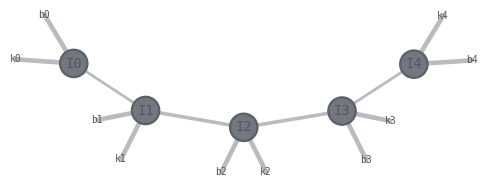

In [18]:
MPO = get_MPO(cov)
MPO.draw()

In [19]:
dmrg = qtn.DMRG1(MPO, bond_dims=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,100], cutoffs=1.e-10)
dmrg.opts["local_eig_backend"] = "lobpcg"
dmrg.solve(verbosity=1,max_sweeps=20)

1, R, max_bond=(1/1), cutoff:1e-10


100%|############################################| 5/5 [00:00<00:00, 166.01it/s]

Energy: 58.966920758231225 ... not converged.
2, R, max_bond=(1/2), cutoff:1e-10



100%|############################################| 5/5 [00:00<00:00, 180.77it/s]

Energy: 44.55123785642482 ... not converged.
3, R, max_bond=(2/3), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 95.39it/s]

Energy: 35.699808298798686 ... not converged.
4, R, max_bond=(3/4), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 64.37it/s]

Energy: 31.311990608574497 ... not converged.
5, R, max_bond=(4/5), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 42.78it/s]

Energy: 28.74030749214014 ... not converged.
6, R, max_bond=(5/6), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 28.61it/s]

Energy: 26.275648111706268 ... not converged.
7, R, max_bond=(6/7), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00,  9.50it/s]

Energy: 24.285494887518247 ... not converged.
8, R, max_bond=(7/8), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00,  7.18it/s]

Energy: 22.64809346685553 ... not converged.
9, R, max_bond=(8/9), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00,  6.80it/s]

Energy: 21.546578496099524 ... not converged.
10, R, max_bond=(9/10), cutoff:1e-10



100%|#############################################| 5/5 [00:01<00:00,  4.12it/s]

Energy: 20.739207192212426 ... not converged.
11, R, max_bond=(10/20), cutoff:1e-10



100%|#############################################| 5/5 [00:02<00:00,  1.75it/s]

Energy: 17.041091367374275 ... not converged.
12, R, max_bond=(20/30), cutoff:1e-10



100%|#############################################| 5/5 [00:02<00:00,  2.29it/s]

Energy: 15.109155099348978 ... not converged.
13, R, max_bond=(30/40), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00,  7.61it/s]

Energy: 14.23057719259414 ... not converged.
14, R, max_bond=(40/50), cutoff:1e-10



100%|#############################################| 5/5 [00:01<00:00,  4.97it/s]

Energy: 13.769395428737337 ... not converged.
15, R, max_bond=(50/100), cutoff:1e-10



100%|#############################################| 5/5 [00:02<00:00,  2.27it/s]

Energy: 13.360204500417094 ... not converged.
16, R, max_bond=(100/100), cutoff:1e-10



100%|#############################################| 5/5 [00:02<00:00,  2.35it/s]

Energy: 13.357208041315376 ... not converged.
17, R, max_bond=(100/100), cutoff:1e-10



100%|#############################################| 5/5 [00:01<00:00,  2.75it/s]

Energy: 13.357197454177545 ... converged!


True

We can now compare it to performing the optimization in the optimal local basis:

In [21]:
#The function below constructs the S matrix 
#that diagonalizes the submatrices of the covariance matrix.
#The singular values can be used to assess the degree of error introduced by the fock basis cutoff (see e.g. 'Data/fig2/source_code_for_figure.ipynb').
def gen_S(cov):
    from scipy.linalg import block_diag
    from strawberryfields.decompositions import williamson
    Ss = []
    Svs = []
    N = cov.shape[0]//2
    for i in range(N):
        sub_cov = cov[[i,i+N],:][:,[i,i+N]]
        db, S = williamson(sub_cov)
        Ss.append(S)
        Svs.append(db[0,0])
    return block_diag(*Ss)[[i for i in range(0,2*N,2)]+[i for i in range(1,2*N,2)],:][:,[i for i in range(0,2*N,2)]+[i for i in range(1,2*N,2)]], Svs
S, SingularValues = gen_S(cov)
MPO_OLB = get_MPO(np.linalg.inv(S)@cov@np.linalg.inv(S.T))

In [22]:
dmrg_OLB = qtn.DMRG1(MPO_OLB, bond_dims=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,100], cutoffs=1.e-10)
dmrg_OLB.opts["local_eig_backend"] = "lobpcg"
dmrg_OLB.solve(verbosity=1,max_sweeps=20)

1, R, max_bond=(1/1), cutoff:1e-10


100%|############################################| 5/5 [00:00<00:00, 188.61it/s]

Energy: 59.846289416619015 ... not converged.
2, R, max_bond=(1/2), cutoff:1e-10



100%|############################################| 5/5 [00:00<00:00, 216.05it/s]

Energy: 44.552396164802786 ... not converged.
3, R, max_bond=(2/3), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 24.20it/s]

Energy: 37.75696486502191 ... not converged.
4, R, max_bond=(3/4), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 23.64it/s]

Energy: 33.24599913981069 ... not converged.
5, R, max_bond=(4/5), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 27.51it/s]

Energy: 27.093926418893087 ... not converged.


6, R, max_bond=(5/6), cutoff:1e-10


100%|#############################################| 5/5 [00:00<00:00, 30.11it/s]

Energy: 24.22156728786567 ... not converged.
7, R, max_bond=(6/7), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 24.70it/s]

Energy: 21.84328744705963 ... not converged.
8, R, max_bond=(7/8), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 11.43it/s]

Energy: 20.500776549526183 ... not converged.
9, R, max_bond=(8/9), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 14.87it/s]

Energy: 19.819716108297857 ... not converged.
10, R, max_bond=(9/10), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 27.92it/s]

Energy: 18.499319218442494 ... not converged.
11, R, max_bond=(10/20), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00, 16.43it/s]

Energy: 13.319924802880667 ... not converged.
12, R, max_bond=(20/30), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00,  7.21it/s]

Energy: 10.688861109533978 ... not converged.
13, R, max_bond=(30/40), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00,  5.61it/s]

Energy: 9.146480819572396 ... not converged.
14, R, max_bond=(40/50), cutoff:1e-10



100%|#############################################| 5/5 [00:00<00:00,  5.21it/s]

Energy: 8.103935611392023 ... not converged.
15, R, max_bond=(50/100), cutoff:1e-10



100%|#############################################| 5/5 [00:03<00:00,  1.63it/s]

Energy: 6.65454701012963 ... not converged.
16, R, max_bond=(100/100), cutoff:1e-10



100%|#############################################| 5/5 [00:02<00:00,  2.47it/s]

Energy: 6.652925798244561 ... not converged.
17, R, max_bond=(100/100), cutoff:1e-10



100%|#############################################| 5/5 [00:01<00:00,  2.56it/s]

Energy: 6.652897669245769 ... converged!


True

Recall that the energy is a heuristic for the simulation error. Where an energy of less than 1 indicates that the variational state will align in large part with the true state. To see how 'erroneous' these simulations are and how well the fock basis compares to the optimal local basis, we can compare to the true amplitudes as calculated by thewalrus.

Note that we can always increase 'D' and/or the maximum bond-dimension in order to converge onto an exact simulation.

In [23]:
import itertools

#Define all possible out combinations below some cutoff (the odd combinations will be zero)
cutoff = 7
combinations = [''.join(map(str, comb)) for comb in itertools.product(range(cutoff), repeat=N) if sum(comb) % 2 == 0]
print("Number of amplitudes to calculate: ", len(combinations))

#Calculate the true amplitudes via thewalrus (approximate runtime is less than a minute)
twamps = [tw.quantum.pure_state_amplitude(np.zeros(2*N),cov,list(map(int, list(comb)))) for comb in combinations]
twAmps = np.abs(np.asarray(twamps))

Number of amplitudes to calculate:  8404


In [24]:
#Calculate the amplitudes from the DMRG state (with no optimized local basis)
amps = [dmrg.state.amplitude(comb) for comb in combinations]
Amps = np.abs(np.asarray(amps))

In [25]:
#Calculate the amplitudes from the DMRG state (with the optimal local basis)
#To this end we need to transform back to the Fock basis. This is done by the following function.
def transform_basis(psi,S,Dout):
    from copy import deepcopy
    import strawberryfields as sf
    state = deepcopy(psi)

    Us = []
    
    for n in range(N):
        U = np.zeros((Dout,D),dtype=np.complex128)
        
        for Din in range(D):
            prog = sf.Program(1)
            with prog.context as q:
                sf.ops.Fock(Din) | q
                sf.ops.GaussianTransform(S[np.ix_([n,n+N],[n,n+N])]) | q

            eng = sf.Engine("fock", backend_options={"cutoff_dim": Dout})
            results = eng.run(prog)
            U[:,Din] = results.state.ket()
        
        Us.append(U)

    for i, U in enumerate(Us):
        state = state.gate(U, str(i), contract=True)
        
    return state, Us

state, Us = transform_basis(dmrg_OLB.state,S,D*2)

amps_OLB = [state.amplitude(comb) for comb in combinations]
Amps_OLB = np.abs(np.asarray(amps_OLB))

Text(0.5, 1.0, 'Comparing the true amplitudes with the variational ones. \n (increase D or the maximum bond dimension for better results)')

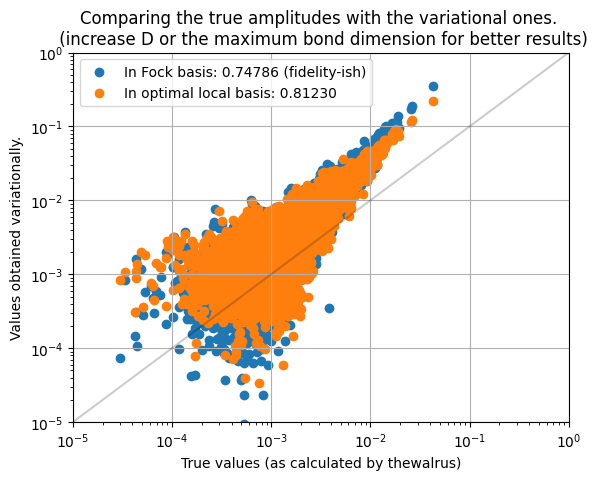

In [26]:
fidel = np.abs(np.vdot(twamps,amps)/np.sqrt(np.vdot(twamps,twamps)*np.vdot(amps,amps)))**2
plt.scatter(twAmps,Amps,label=f"In Fock basis: {fidel:.5f} (fidelity-ish)")
fidel_OLB = np.abs(np.vdot(twamps,amps_OLB)/np.sqrt(np.vdot(twamps,twamps)*np.vdot(amps_OLB,amps_OLB)))**2
plt.scatter(twAmps,Amps_OLB,label=f"In optimal local basis: {fidel_OLB:.5f}")
plt.plot([1e-5,1],[1e-5,1],color="black",alpha=0.2)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-5,1)
plt.ylim(1e-5,1)
plt.xlabel("True values (as calculated by thewalrus)")
plt.ylabel("Values obtained variationally.")
plt.grid()
plt.legend()
plt.title("Comparing the true amplitudes with the variational ones. \n (increase D or the maximum bond dimension for better results)")

As we see, since the variational energy is 'far' from 0, the simulated amplitudes and the true amplitudes will not completely align. However, both variational states still share a surprisingly large overlap with the true state. The optimal local basis yields a better simulation both in terms of the energy and the overlap, as expected.